# ПР8 Аналіз текстів

*Мета роботи*: ознайомитись з методами аналізу текстів.


In [1]:
from bs4 import BeautifulSoup
import csv
import pandas as pd
import re
import spacy
from collections import Counter
from string import punctuation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

##### Очистимо дані від тегів та розмітки

In [2]:
with open('text.html', 'r', encoding='utf-8') as file:
    html_content = file.read()
    
soup = BeautifulSoup(html_content, 'html.parser')

paragraphs = soup.find_all('p')
text = ''
for p in paragraphs[1:]:
    text += p.get_text() + '\n'


##### Виконаємо токенізацію

In [3]:
nlp = spacy.load('uk_core_news_sm')
doc = nlp(text)
tokens = [token for token in doc if not token.is_stop and not token.is_punct and not token.is_space and re.match(r'\w+', token.text)]


##### Виконаємо лематизацію тексту та збережемо результат в csv-файлі.


In [4]:
lemmatized_text = [token.lemma_ for token in tokens]
pd.DataFrame(lemmatized_text).to_csv('lemmatized_text.csv', encoding='cp1251')

##### Створимо Bag of Words та збережемо результат в csv-файлі.

In [5]:
bag_of_words = dict(Counter(lemmatized_text))
bow_df = pd.DataFrame(list(bag_of_words.items()), columns=['word', 'count'])
bow_df.sort_values('count', ascending=False, inplace=True)
bow_df.to_csv('bag_of_words.csv', encoding='cp1251')
bow_df.head(10)

,word,count
0,іван,148
105,гора,93
823,марічка,65
24,ліс,63
41,око,61
380,нога,60
40,од,59
760,рука,55
826,вівця,52
2546,палагна,50


##### Обчислимо TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

top10_words = bow_df.head(10).word
words_list = [word for word, count in bag_of_words.items() for _ in range(count)]

corpus = [' '.join(words_list)]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
tfidf_values = X.toarray()[0]

df_tfidf = pd.DataFrame({'Word': feature_names, 'TF-IDF': tfidf_values})
df_tfidf = df_tfidf.sort_values(by='TF-IDF', ascending=False).head(10)

total_words = sum(bag_of_words.values())
df_tfidf['TF'] = df_tfidf['Word'].map(lambda x: bag_of_words.get(x, 0) / total_words)

num_documents = 1
df_tfidf['IDF'] = df_tfidf['Word'].map(lambda x: 1 / (1 + bag_of_words.get(x, 0)))

print(df_tfidf)

         Word    TF-IDF        TF       IDF
3964     іван  0.407786  0.014726  0.006711
653      гора  0.256244  0.009254  0.010638
1737  марічка  0.179095  0.006468  0.015152
1709      ліс  0.173585  0.006269  0.015625
2222      око  0.168074  0.006070  0.016129
2154       од  0.168074  0.005871  0.016667
2060     нога  0.165319  0.005970  0.016393
3000     рука  0.151542  0.005473  0.017857
505     вівця  0.143276  0.005174  0.018868
2284  палагна  0.137766  0.004975  0.019608


D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Додаткове завдання 1

##### Імпортуємо дані

In [7]:
ukr_text = pd.read_csv("ukr_text.csv")
ukr_text

,Id,Title,Body
0,http://k.img.com.ua/rss/ua/4013798,Кличко покликав німецьких інвесторів до Києва,Київ - перспективний і відкритий ринок для біз...
1,http://k.img.com.ua/rss/ua/4001679,"З'явилося відео, як байкер почав стріляти у во...",З'явилося відео конфлікту між мотоциклістом...
2,http://k.img.com.ua/rss/ua/4001390,У центрі Києва посеред вулиці помер чоловік,У Києві на Бессарабській площі вранці в четвер...
3,http://k.img.com.ua/rss/ua/4001239,Нічний ураган перетворив Хрещатик на смітник,Київ вночі 16 серпня пережив найсильнішу грозу...
4,http://k.img.com.ua/rss/ua/4001227,Потоп у Києві: столицю накрив ураган з градом,Уночі Київ вкотре накрила негода. Найсильніший...
...,...,...,...
1117,http://k.img.com.ua/rss/ua/3194862,Корреспондент: Діамантові руки. Історія успіху...,Київський офіс Класичного ювелірного дому Лобо...
1118,http://k.img.com.ua/rss/ua/3194633,Корреспондент: Роздача слонів. Янукович щедро ...,20 років тому орден За заслуги – тоді він нази...
1119,http://k.img.com.ua/rss/ua/3194587,Корреспондент: Рівняння з трьома відомими. Укр...,10 жовтня політичні важковаговики з табору опо...
1120,http://k.img.com.ua/rss/ua/3194570,Корреспондент: Точка зору. Мета обкрадає кошти...,"Добре там, де нас немає. В Ізраїлі ми є, але т..."


##### Імпортуємо словник тональностей

In [8]:
tone_dictionary = {}

with open('tone-dict-uk.tsv', 'r', encoding='utf-8') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        word, sentiment = row
        tone_dictionary[word] = sentiment

##### Токенізуємо та лематизуємо наші тексти

In [9]:
nlp = spacy.load("uk_core_news_sm")
def tokenize_and_lemmatize(text):
    lemmatized_words = [token.lemma_.lower() for token in nlp(text.translate(str.maketrans('', '', punctuation + '«»—–’')))]
    return [word for word in lemmatized_words if word not in nlp.Defaults.stop_words and re.match(r"\w", word)]

##### Додамо стовпець з токенізованим текстом

In [10]:
ukr_text['Tokenized_Body'] = ukr_text['Body'].apply(tokenize_and_lemmatize)
ukr_text

,Id,Title,Body,Tokenized_Body
0,http://k.img.com.ua/rss/ua/4013798,Кличко покликав німецьких інвесторів до Києва,Київ - перспективний і відкритий ринок для біз...,"[київ, перспективний, відкритий, ринок, бізнес..."
1,http://k.img.com.ua/rss/ua/4001679,"З'явилося відео, як байкер почав стріляти у во...",З'явилося відео конфлікту між мотоциклістом...,"[зявитися, відео, конфлікт, мотоцикліст, водій..."
2,http://k.img.com.ua/rss/ua/4001390,У центрі Києва посеред вулиці помер чоловік,У Києві на Бессарабській площі вранці в четвер...,"[кий, бессарабський, площа, вранці, четвер, 16..."
3,http://k.img.com.ua/rss/ua/4001239,Нічний ураган перетворив Хрещатик на смітник,Київ вночі 16 серпня пережив найсильнішу грозу...,"[київ, вночі, 16, серпень, пережити, найсильні..."
4,http://k.img.com.ua/rss/ua/4001227,Потоп у Києві: столицю накрив ураган з градом,Уночі Київ вкотре накрила негода. Найсильніший...,"[уночі, київ, вкотре, накрити, негода, найсиль..."
...,...,...,...,...
1117,http://k.img.com.ua/rss/ua/3194862,Корреспондент: Діамантові руки. Історія успіху...,Київський офіс Класичного ювелірного дому Лобо...,"[київський, офіс, класичний, ювелірний, дім, л..."
1118,http://k.img.com.ua/rss/ua/3194633,Корреспондент: Роздача слонів. Янукович щедро ...,20 років тому орден За заслуги – тоді він нази...,"[20, орден, заслуга, називатися, почесний, зна..."
1119,http://k.img.com.ua/rss/ua/3194587,Корреспондент: Рівняння з трьома відомими. Укр...,10 жовтня політичні важковаговики з табору опо...,"[10, жовтень, політичний, важковаговик, табір,..."
1120,http://k.img.com.ua/rss/ua/3194570,Корреспондент: Точка зору. Мета обкрадає кошти...,"Добре там, де нас немає. В Ізраїлі ми є, але т...","[ізраїль, країна, займати, місце, світ, надій,..."


##### Визначимо тональність текстів

In [11]:
def analyze_sentiment(text):
    words = text
    total = 0

    for word in words:
        if word in tone_dictionary:
            sentiment = tone_dictionary[word]
            total += int(sentiment)

    if total > 0:
        return 'Positive'
    elif total < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [12]:
ukr_text['Тональність'] = ukr_text.Tokenized_Body.apply(analyze_sentiment)
ukr_text

,Id,Title,Body,Tokenized_Body,Тональність
0,http://k.img.com.ua/rss/ua/4013798,Кличко покликав німецьких інвесторів до Києва,Київ - перспективний і відкритий ринок для біз...,"[київ, перспективний, відкритий, ринок, бізнес...",Positive
1,http://k.img.com.ua/rss/ua/4001679,"З'явилося відео, як байкер почав стріляти у во...",З'явилося відео конфлікту між мотоциклістом...,"[зявитися, відео, конфлікт, мотоцикліст, водій...",Negative
2,http://k.img.com.ua/rss/ua/4001390,У центрі Києва посеред вулиці помер чоловік,У Києві на Бессарабській площі вранці в четвер...,"[кий, бессарабський, площа, вранці, четвер, 16...",Negative
3,http://k.img.com.ua/rss/ua/4001239,Нічний ураган перетворив Хрещатик на смітник,Київ вночі 16 серпня пережив найсильнішу грозу...,"[київ, вночі, 16, серпень, пережити, найсильні...",Negative
4,http://k.img.com.ua/rss/ua/4001227,Потоп у Києві: столицю накрив ураган з градом,Уночі Київ вкотре накрила негода. Найсильніший...,"[уночі, київ, вкотре, накрити, негода, найсиль...",Negative
...,...,...,...,...,...
1117,http://k.img.com.ua/rss/ua/3194862,Корреспондент: Діамантові руки. Історія успіху...,Київський офіс Класичного ювелірного дому Лобо...,"[київський, офіс, класичний, ювелірний, дім, л...",Positive
1118,http://k.img.com.ua/rss/ua/3194633,Корреспондент: Роздача слонів. Янукович щедро ...,20 років тому орден За заслуги – тоді він нази...,"[20, орден, заслуга, називатися, почесний, зна...",Positive
1119,http://k.img.com.ua/rss/ua/3194587,Корреспондент: Рівняння з трьома відомими. Укр...,10 жовтня політичні важковаговики з табору опо...,"[10, жовтень, політичний, важковаговик, табір,...",Positive
1120,http://k.img.com.ua/rss/ua/3194570,Корреспондент: Точка зору. Мета обкрадає кошти...,"Добре там, де нас немає. В Ізраїлі ми є, але т...","[ізраїль, країна, займати, місце, світ, надій,...",Positive


##### Преобразуємо текстові дані в числові представлення

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

ukr_text["Lemmas"] = ukr_text["Tokenized_Body"].str.join(" ")
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(ukr_text["Lemmas"])
svd_vectorizer = TruncatedSVD(n_components=10, random_state=1)
X_lsa = svd_vectorizer.fit_transform(X)

##### Отримаємо найбільш важливі слова в текстах та виділимо 10 категорій:

In [14]:
from numpy import argsort
def get_topic_words(vectorizer, svd, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for component in svd.components_:
        top_words_idx = argsort(component)[::-1][:n_top_words]
        top_words = [words[i] for i in top_words_idx]
        topics.append(top_words)
    return topics
topics = get_topic_words(tfidf_vectorizer, svd_vectorizer, 10)
for i, topic in enumerate(topics):
    print(f'Topic {i} {", ".join(topic)}')

Topic 0 україна, рок, долар, компанія, росія, свій, газ, новий, країна, грудень
Topic 1 індекс, долар, біржа, пункт, нафта, барель, марка, торг, ньюйоркський, brent
Topic 2 газ, україна, транзит, область, млрд, нафтогаз, регіон, газпром, грн, інвестиція
Topic 3 область, індекс, регіон, пункт, інвестиція, душа, населення, завод, виробництво, підприємство
Topic 4 індекс, пункт, jones, dow, nasdaq, фондовий, 500, виборчий, ринок, sp
Topic 5 виборчий, цвк, округ, комісія, депутат, народний, серпень, вибори, зареєструвати, обраний
Topic 6 гонка, область, кубок, україна, регіон, підручний, естафета, змішаний, етап, варвинець
Topic 7 матч, динамо, гра, мяч, шахтар, штрафний, пробити, олександрія, команда, очко
Topic 8 мерседес, феррарі, феттель, хемілтон, гранпрі, боттас, райкконен, себастьян, льюїс, булл
Topic 9 санкція, північний, росія, учасник, шоу, газопровід, випуск, конкурс, мастершеф, президент


##### Додамо інформацію про визначені категорії текстів у наш датасет

In [16]:
ukr_text['Topic'] = X_lsa.argmax(axis=1)
ukr_text[ukr_text.Topic == 2]

,Id,Title,Body,Tokenized_Body,Тональність,Lemmas,Topic
99,http://k.img.com.ua/rss/ua/4176442,Єрмак назвав дату підписання договору про транзит,Україна і Росія мають намір підписати контракт...,"[україна, росія, намір, підписати, контракт, т...",Negative,україна росія намір підписати контракт транзит...,2
205,http://k.img.com.ua/rss/ua/4175427,Нафтогаз: Складне узгодження контрактів з Газп...,Виконавчий директор Нафтогазу Юрій Вітренко на...,"[виконавчий, директор, нафтогаз, юрій, вітренк...",Positive,виконавчий директор нафтогаз юрій вітренко сві...,2
213,http://k.img.com.ua/rss/ua/4174784,Тарифи на газ цієї зими не зростуть - Гончарук,Завдяки домовленості про транзит російського г...,"[завдяки, домовленість, транзит, російський, г...",Positive,завдяки домовленість транзит російський газ єв...,2
225,http://k.img.com.ua/rss/ua/4175427,Нафтогаз: Складне узгодження контрактів з Газп...,Виконавчий директор Нафтогазу Юрій Вітренко на...,"[виконавчий, директор, нафтогаз, юрій, вітренк...",Positive,виконавчий директор нафтогаз юрій вітренко сві...,2
233,http://k.img.com.ua/rss/ua/4174784,Тарифи на газ цієї зими не зростуть - Гончарук,Завдяки домовленості про транзит російського г...,"[завдяки, домовленість, транзит, російський, г...",Positive,завдяки домовленість транзит російський газ єв...,2
595,http://k.img.com.ua/rss/ua/4176442,Єрмак назвав дату підписання договору про транзит,Україна і Росія мають намір підписати контракт...,"[україна, росія, намір, підписати, контракт, т...",Negative,україна росія намір підписати контракт транзит...,2
799,http://k.img.com.ua/rss/ua/4175370,"Тариф на транзит газу буде ""гуманним"" - Медведєв",Вартість транзиту російського газу через терит...,"[вартість, транзит, російський, газ, територія...",Positive,вартість транзит російський газ територія укра...,2
825,http://k.img.com.ua/rss/ua/4175533,"У Раді визнали, що Україна купує російський газ","Україна купує російський газ, попередньо прока...","[україна, купувати, російський, газ, попереднь...",Negative,україна купувати російський газ попередньо про...,2
828,http://k.img.com.ua/rss/ua/4175159,Ціна на транзит буде встановлена на п'ять рокі...,На газових переговорах було досягнуто згоди пр...,"[газовий, переговори, досягнути, згода, фіксов...",Negative,газовий переговори досягнути згода фіксований ...,2
832,http://k.img.com.ua/rss/ua/4174611,РФ і Україна підпишуть мирову угоду щодо газу,"Газпром укладе мирову угоду з владою України, ...","[газпром, укласти, мировий, угода, влада, укра...",Positive,газпром укласти мировий угода влада україна пе...,2


## Додаткове завдання 2

In [74]:
with open('doyle.txt', 'r') as file:
    doyle = file.read()
with open('doyle-2.txt', 'r') as file:
    doyle2 = file.read()
with open('poe.txt', 'r') as file:
    poe = file.read()
with open('poe-2.txt', 'r') as file:
    poe2 = file.read()

##### Завантажимо необхідні дані

In [75]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

##### Лематизуємо тексти

In [76]:
lemmatized_words1 = [doc.lemma_ for doc in nlp(doyle)]
lemmatized_words2 = [doc.lemma_ for doc in nlp(doyle2)]
lemmatized_doyle_text = [word for word in lemmatized_words1 if word not in stop_words and re.match(r'\w+', word)]
lemmatized_doyle_text += [word for word in lemmatized_words2 if word not in stop_words and re.match(r'\w+', word)]

lemmatized_words1 = [doc.lemma_ for doc in nlp(poe)]
lemmatized_words2 = [doc.lemma_ for doc in nlp(poe2)]
lemmatized_poe_text = [word for word in lemmatized_words1 if word not in stop_words and re.match(r'\w+', word)]
lemmatized_poe_text += [word for word in lemmatized_words2 if word not in stop_words and re.match(r'\w+', word)]

##### Отримаємо bag of words для обох текстів

In [77]:
bow_doyle = dict(Counter(lemmatized_doyle_text))
bow_poe = dict(Counter(lemmatized_poe_text))

##### Намалюємо wordcloud

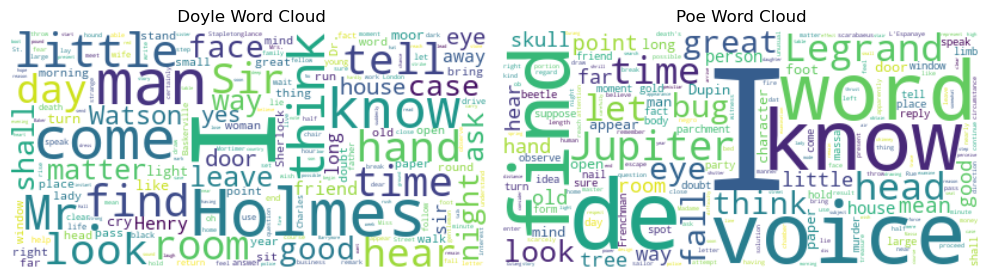

In [78]:
from wordcloud import WordCloud

wordcloud1 = WordCloud(background_color='white')
wordcloud1.generate_from_frequencies(bow_doyle)

wordcloud2 = WordCloud(background_color='white')
wordcloud2.generate_from_frequencies(bow_poe)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title(' Doyle Word Cloud')

axes[1].imshow(wordcloud2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Poe Word Cloud')

plt.tight_layout()

plt.show()

##### Завантажимо словник тональності

In [79]:
tone_dictionary = {}
with open('AFINN-111.txt', 'r') as file:
    for line in file:
        line = line.strip() 
        if line:
            word, value = line.split('\t')
            tone_dictionary[word] = float(value)

##### Визначимо функцію для обчислення тональності тексту

In [84]:
def compute_text_tone(text):
    words = text
    total_tone = 0.0
    counter = 0
    for word in words:
        if word in tone_dictionary:
            if(counter != 10):
                counter+=1
                print(word, ':', tone_dictionary[word])
            total_tone += tone_dictionary[word]

    return total_tone

##### Визначимо, який з письменників писав більш похмурі оповідання

In [85]:
if (compute_text_tone(lemmatized_doyle_text) < compute_text_tone(lemmatized_poe_text)):
    print('А.К. Дойль писав більш похмурі оповідання.')
else:
    print('Е.По писав більш похмурі оповідання.')

save : 2.0
leave : -1.0
fine : 2.0
solid : 2.0
reassure : 1.0
miss : -2.0
accidental : -2.0
importance : 2.0
successful : 3.0
appreciation : 2.0
mad : -3.0
wealthy : 2.0
want : 1.0
avoid : -1.0
disaster : -2.0
leave : -1.0
favorite : 2.0
miserable : -3.0
hard : -1.0
sweet : 2.0
Е.По писав більш похмурі оповідання.
